# Scraping LADOT Volume Data from PDFs

## Background
At LADOT, we have a lot of historical (and relatively current) data on vehicle volume counts made at intersections throughout the city at various times. The problem is that the format the data are currently in - PDF - doesn't readily allow for the type of big data analyses that we would like to perform. So for this task I went about trying to develop a method for scraping these historical PDF counts and formatting them into usable data tables using any python package I could. I ended up settling on the pdfquery package, which is really just a lightweight wrapper around the much more well-known package PDFMiner.

The roughly 1,000 PDFs typically (though not always) look like this (converted to images for display here):

![Example Volume PDF](images/example.jpg?raw=TRUE)

##### Format Advantages
* One big advantage is that the (manual count) volume data sheets are generally in the same format.
* With very few exceptions, the PDFs were generated from another program (rather than being scanned images).

##### Format Challenges
There are a few minor challenges:
* There are multiple tables on each page, and each is formatted differently.
* The tables / text do not always appear in the exact same location on each page, which meant I needed a range of parameters to test for the bounding boxes.

## General Approach
My approach can be broken down into the few key parts: (1) define bounding boxes, (2) search for text within the bounding boxes (3) reformat the resulting text into multiple data tables, and (4) join the resulting tables to the ID established by the Bureau of Engineering. 

##### Define Bounding Boxes
This was tricky. I initially began defining bounding boxes using pixel measurements from a few sample pages. However, I quickly realized that due to the second of the challenges I mentioned above that this would not work, since the tables are in different locations among the PDF documents. 

Instead, I decided to create bounding boxes on the fly for each document using relative positioning of certain keywords that appeared almost always on each PDF document. Using pdfquery, I could begin by searching the document for these keywords and then extract the x,y pixel coordinate locations for the bounding box of each one. By getting the coordinates of multiple keyword objects on the page, I could construct a set of bounding boxes that seemed to perform relatively well in capturing data tables.

(create image of what this looked like)

##### Search for Text within Bounding Boxes
Once I had the coordinates of the bounding boxes, this part was quite easy, using PDFQuery to extract text

(do i need to adjust any of the parameters in rapidminer??)

##### Reformat the Resulting Text into Data Tables
The final problem included taking the scraped text from the bounding boxes and reformatting them into usable data tables. I kept in mind the relational database model as I set the format for these tables. From the PDF image above, I decided on the following tables and attributes:

*tbl_manualcount_info:* This table contains the basic information about the manual count summary. Each count will have one tuple with the following information:
* street_ns: The North / South Street running through the intersection
* street_ew: The East / West street running through the intersection
* dayofweek: Day of the Week
* date: Date, in datetime format
* weather: Prevailing weather at the time of the count (Clear, Sunny, etc.)
* hours: the hours of the count (text)
* school_day: A Yes / No indication of whether the count occurred on a school day. This is important because it heavily affects the volume counts
* int_code: The "I/S Code" on the form corresponds to the CL_Node_ID on the BOE Centerline. This ID field makes it easy to join to the City's centerline network
* district: The DOT field district in which the count took place
* count_id: Unique identifier assigned to the summary

*tbl_manualcount_dualwheel:* This table contains count data for dual-wheeled (motorcycles), bikes, and buses. Each form will have 12 tuples with the following information:
* count_id: Unique identifier assigned to the summary in "tbl_manual_count_info"
* approach: Intersection approach being measured (N,S,E,W)
* type: Dual-Wheeled / Bikes / Buses
* volume: Count

*tbl_manualcount_peak:* This table contains the peak hour / 15 minute counts. Each form will have 16 tuples with the following information:
* count_id: Unique identifier assigned to the summary in "tbl_manual_count_info"
* approach: Intersection approach being measured (N,S,E,W)
* type: The type of count
    * am_15: The AM peak 15 minute count
    * am_hour: The AM peak hour count
    * pm_15: The PM peak 15 minute count
    * pm_hour: The PM peak hour count
* time: Time of each count (in datetime format)
* volume: Count

*tbl_manualcount_volumes:* This table contains the main volume counts for each approach at the intersection. The number of tuples for each form will vary depending on the number of hours surveyed. A 6-hour count will have 6 hours * 3 directions (left, right, through) * 4 approach directions = 54 tuples. Each tuple will have the following information:
* count_id: Unique identifier assigned to the summary in "tbl_manual_count_info"
* approach: Northbound (NB) / Southbound (SB) / Eastbound (EB) / Westbound (WB)
* movement: Right-Turn (Rt) / Through (Th) / Left-Turn (Lt)
* start_time: Start time of that count, in datetime format
* end_time: End time of that count, in datetime format
* volume: Count

*tbl_manualcount_peds:* This table contains pedestrian and schoolchildren counts during the same time as the main volume counts, so the number of tuples will also be dependent on the number of hours the location was surveyed. Each tuple will have the following information:
* count_id: Unique identifier assigned to the summary in "tbl_manual_count_info"
* xing_leg: The leg of the intersection that is being crossed. South Leg (SL) / North Leg (NL) / West Leg (WL) / East Leg (EL)
* type: Ped / Sch
* start_time: Start time of that count, in datetime format
* end_time: End time of that count, in datetime format
* volume: Count

##### Join Tables to BOE Count IDs
The last step involves taking all the data generated by this process and relating it to both a GPS coordinate and the intersection ID of the BOE centerline.

To do this exercise, I requested data from BOE that powers NavigateLA. There are actually two relevant tables that were provided by BOE. The first table, *dbo_dot_traffic_data_files* relates the name of the PDF to a TrafficID, so I can use this table to match the PDF names and get the resulting Traffic IDs. The second table, *dot_traffic_data* takes the TrafficID and relates it to the intersection ID (the same one that is usually on the front page of each traffic count summary) as well as the the lat / lon of the location and the intersection name. The structure of the two tables are shown below:

*dbo_dot_traffic_data_files*
* ID: Unique Identifier for the count
* TrafficID: This seems to be an identifier for the location
* TrafficType: Manual Count (manual_count) / Automatic Count (automatic_count) / Survey Data (survey_data)
* DocName: Name of the PDF document
* UniqueDocName: Not exactly sure the purpose of this one, perhaps at one time the DocNames were not unique?
* UploadDT: Date the PDF was uploaded to NavLA

*dot_traffic_data*
* TrafficID: Identifier for the location
* Intersection: The ID for the intersection, corresponding to the CL_NODE_ID in the BOE Centerline file
* ext: ?
* lat: Latitude
* lon: Longitude
* intersection: Intersection Name (eg ISLAND AVE at L ST)
* Shape: geometry object

In [3]:
### Setup
import csv
import glob
from datetime import datetime, date, time
import pdfquery
import pandas as pd
import numpy as np
import folium
import os


### Getting Started
I'm actually going to start by loading and cleaning the tables provided by BOE (mentioned just above). 

In [1]:
# Load traffic data files table
traffic_data_files_path = 'boe_tables/dbo_dot_traffic_data_files.csv'
dbo_dot_traffic_data_files = pd.read_csv(traffic_data_files_path, parse_dates=['UploadDT'], encoding="ISO-8859-1")

# Drop rows where TrafficID is NaN, convert TrafficID to int type
dbo_dot_traffic_data_files = dbo_dot_traffic_data_files.dropna(axis=0, how='any',subset=['TrafficID'])
dbo_dot_traffic_data_files['TrafficID'] = dbo_dot_traffic_data_files['TrafficID'].astype(int)

# Subset out Survey Data and Automatic Counts
dbo_dot_traffic_data_files = dbo_dot_traffic_data_files[(dbo_dot_traffic_data_files['TrafficType'] == 'manual_count')]

# See traffic data files head
print("There are " + str(len(dbo_dot_traffic_data_files)) + " records in the table.")
dbo_dot_traffic_data_files

NameError: name 'pd' is not defined

I went ahead ane excluded any rows where the TrafficID was NaN (there was one value) since we would not be able to associate that to a valid intersection or location.

In [9]:
# Load traffic data table
traffic_data_path = 'boe_tables/dot_traffic_data.csv'
dot_traffic_data = pd.read_csv(traffic_data_path)

# Drop "ext" and "Shape" columns
dot_traffic_data = dot_traffic_data.drop(['ext','Shape'], axis=1)

# See traffic data head
dot_traffic_data[pd.isnull(dot_traffic_data['IntersectionID'])].head()

,TrafficID,IntersectionID,lat,lon,intersection
1912,3798,NaN,34.11,-118.25,
1917,3803,NaN,33.78,-118.25,
3129,3097,NaN,33.76,-118.29,
3131,3099,NaN,34.17,-118.40,WHITSETT AV AT OXNARD ST
3143,3111,NaN,34.00,-118.28,Mid Block Ped Count Zone 3


Now, looking at *dot_traffic_data* table, I first excluded the 'ext' and 'Shape' columns. Of note, there are a number of counts that have a NaN value for the IntersectionID. Some of these may have incorrectly been assigned to an intersection, but (as shown with the "intersection' value of TrafficID 3111) many are midblock counts that won't have a valid intersection ID at all. Since these rows have valid lat / lon values, we can confirm this on a map using the Python Folium package.

Even though these aren't at an intersection, most of them still have some sort of description value in the 'intersection' field. Along with plotting the locations using the lat / lon, I've added the labels to the points (click the point to see the label). After taking a look, I can confirm that many points are midblock locations. However, there are others that look like they are intersections, but perhaps just not locations on the BOE centerline. For example, there are three different locations that have to do with counts at Forest Lawn Dr and some other driveway. It is likely that these intersections don't exist in the valid BOE centerline file, which is why they don't contain a valid IntersectionID.

Also of note - it looks like the points aren't plotted at exactly the right position. This is likely due to the fact that the lat / lon coords provided in the BOE table only go to two decimal places. I'm guessing that somehow the rest of values are getting cut off.

In [1]:
# Create new LA Basemap specifying map center, zoom level, and using Stamen Toner Tiles
midblock_map = folium.Map([34.109279, -118.266087],
                          tiles='Stamen Toner',
                          zoom_start=11)

# Subset out points with a NaN Intersection ID 
midblock_points = dot_traffic_data[pd.isnull(dot_traffic_data['IntersectionID'])]

# Loop through the midblock_points df, add each point and value for 'intersection' column to the map
for index, row in midblock_points.iterrows():
    folium.Marker([row['lat'], row['lon']], popup=str(row['intersection'])).add_to(midblock_map)

# Show the map
midblock_map

NameError: name 'folium' is not defined

The next step is to prepare dataframes for each of the volume-related tables (except the ones designated by BOE) discussed above. 

In [11]:
### Create Dataframes for each table

# tbl_manualcount_info
info_columns = ['street_ns','street_ew','dayofweek','date','weather','hours','school_day','int_code','district','count_id']
tbl_manualcount_info = pd.DataFrame(columns=info_columns)

# tbl_manualcount_dualwheel
dualwheel_columns = ['count_id','approach','type','volume']
tbl_manualcount_dualwheel = pd.DataFrame(columns=dualwheel_columns)

# tbl_manualcount_peak
peak_columns = ['count_id','approach','type','time','volume']
tbl_manualcount_peak = pd.DataFrame(columns=peak_columns)

# tbl_manualcount_volumes
vol_columns = ['count_id','approach','movement','start_time','end_time','volume']
tbl_manualcount_volumes = pd.DataFrame(columns=vol_columns)

# tbl_manualcount_peds
ped_columns = ['count_id','xing_leg','type','start_time','end_time','volume']
tbl_manualcount_peds = pd.DataFrame(columns=ped_columns)

Once I have the dataframe table structures, the next step involves looping through all the manual count PDFs, running my text extract function, and then inserting the rows into the appropriate tables. The following explains each step in more detail:

##### Step 1: Make sure I have all the Volume Data PDFs (prep) and Related TraffcIDs
I knew we needed to be able to join all of the data we pull out of the PDF to the table provided by BOE. Since the BOE Table *dbo_dot_traffic_data_files* contains a field with the filename, this is an easy join with our filename. Once this join is complete we will have the TrafficID.

My initial process for doing this involved just looping through *dbo_dot_traffic_data_files* (after subsetting for the manual counts as I did above), and then just grabbing a file with the same filename in my folder, but then I realized that there were many rows that did not have a PDF in the folder. By doing the join, I could easily identify which PDFs were missing.

I went a bit further - to get a graphical sense of the differences, I went ahead and created a venn diagram showing the results of the join from the BOE table and my folder of manual PDF counts. As you can tell, there is quite a difference.

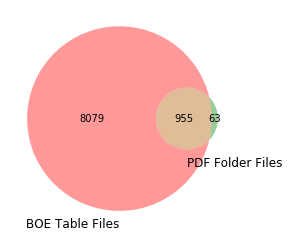

In [7]:
# Get Venn Diagram package
from matplotlib import pyplot as plt
from matplotlib_venn import venn2, venn2_circles

# Grab all PDFs within the folder
files = glob.glob('TrafficCountData\Manual\Original\*.pdf')
file_names = [os.path.basename(file) for file in files]

# Create df from filenames / paths
pdf_df = pd.DataFrame(
    {'path':files,
     'filename':file_names
    })

# Join pdf_df to BOE tables
traffic_data_files_leftjoin = dbo_dot_traffic_data_files.merge(pdf_df, how='left', left_on='DocName', right_on='filename')
traffic_data_files_innerjoin = dbo_dot_traffic_data_files.merge(pdf_df, how='inner', left_on='DocName', right_on='filename')
traffic_data_files_rightjoin = dbo_dot_traffic_data_files.merge(pdf_df, how='right', left_on='DocName', right_on='filename')

### Create Venn Diagram showing differences

# Subset sizes
s = (
    (len(traffic_data_files_leftjoin) - len(traffic_data_files_innerjoin)),  # BOE Table only count
    (len(traffic_data_files_rightjoin)-len(traffic_data_files_innerjoin)),  # PDF Folder only count
    len(traffic_data_files_innerjoin),  # Joined Files count
)

# Subset labels
v = venn2(subsets=s, set_labels=('BOE Table Files', 'PDF Folder Files'))

# Show the plot
plt.show()

As the Venn Diagram makes obvious, there is quite a difference. Of the 1,018 PDF files I started with, I was able to match 955 (~94%) of them to a row in the BOE table. Roughly 6% of the files (63) were unable to be matched in the BOE table. 

However, it looks like the folder of Manual PDF counts that I was initially pulling from contained only about 10% (1018 of the 9034 total) of the manual count files in BOE's NavigateLA system. We don't have to give up here. Since NavigateLA hosts the PDFs online (and they are public), we can go ahead and download them from the NavigateLA website to fill out our set of Manual Count PDFs. We will do this by (1) looping through all the names in the BOE table that do not have a match and (2) using the python urllib library to pull the PDFs to a new folder.

In [8]:
import urllib
import time
from pathlib2 import Path

# Location to where I will be downloading the files
folder = "TrafficCountData/Manual/All/"

# Base URL 
base_url = "http://boemaps.eng.ci.la.ca.us/dot/traffic_data/manual_counts/"

# Get the filenames from the BOE table that don't yet have a matching PDF
traffic_data_files_missing = traffic_data_files_leftjoin[(~traffic_data_files_leftjoin.DocName.isin(traffic_data_files_innerjoin.DocName))&(~traffic_data_files_leftjoin.filename.isin(traffic_data_files_innerjoin.filename))]

# Loop through resulting rows
for index, row in traffic_data_files_missing.iterrows():
    
    # Filename, URL, Location
    filename = row['DocName']
    url = base_url + filename
    download_location = folder + filename
    
    # If it is already in the folder from first round of NavLA downloads, skip
    if Path(download_location).is_file():
        pass
    
    # Otherwise, try to download
    else:
        
        try:
            # Download to folder
            urllib.urlretrieve(url, download_location)

            # To Not overwhelm the server
            time.sleep(.2)
        
        except:
            pass


##### Step 2: Run the PDF text scraping script (extract / transform)
The powerhouse behind this process is the script I built to read a PDF and extract text into a list of dictionaries (one for each table). Because this script is so long, I opted not to include the code in the notebook, and instead treated it as a module that I imported using "import VolumeCountSheets_V2" above. I call the "pdf_extract" function from the module on each PDF.

##### Step 3: Append each resulting dictionary to the Pandas dataframe (load)
The function returns a list of dictionaries, one for each dataframe. I then take the pandas dataframes I constructed in the cell above and append each dictionary to the appropriate one.

In [21]:
# Import PDF Scrape Module
import VolumeCountSheets_V2

# Setup Counter of sucessful / failed attempts
success = 0
failures = 0

manualcount_volumes = []
ped_volumes = []
peak_volumes = []
info = []
specveh_volumes = []

i = 0
for index, row in dbo_dot_traffic_data_files.iterrows():
    
#     i+=1
#     if i > 100:
#         break
    
    
    # Folder location of all the count PDFs
    fileloc = 'TrafficCountData/Manual/All/' + row['DocName']
    
    # ID for the count
    count_id = row['ID']
    if count_id%100 == 0:
        print "count_id:" + str(count_id)

    try:
        if Path(fileloc).exists():
            success+=1
            
            # Run the extract function
            Manual_TC = VolumeCountSheets_V2.pdf_extract(fileloc)
                             
            # Append each row to our lists
            for m in Manual_TC['Spec_Veh']:
                specveh_volumes.append(m)
            
            for j in Manual_TC['Volume']:
                j['count_id'] = str(count_id)
                manualcount_volumes.append(j)
                
            for k in Manual_TC['Pedestrian']:
                k['count_id'] = str(count_id)
                ped_volumes.append(k)
                
            for l in Manual_TC['PeakVol']:
                l['count_id'] = str(count_id)
                peak_volumes.append(l)
                
            Manual_TC['Info']['count_id'] = str(count_id)
            info.append(Manual_TC['Info'])
                

        else:
            failures += 1
        
    except:
        failures += 1


# Create dataframes from lists of dictionaries
info_df = pd.DataFrame.from_records(info)
manualcount_df = pd.DataFrame.from_records(manualcount_volumes)
pedestrian_df = pd.DataFrame.from_records(ped_volumes)
peakvol_df = pd.DataFrame.from_records(peak_volumes)
specveh_df = pd.DataFrame.from_records(specveh_volumes)

# Save dataframes to CSVs
manualcount_df.to_csv(path_or_buf='TrafficCountData/Results/manualcount.csv',sep=',')
pedestrian_df.to_csv(path_or_buf='TrafficCountData/Results/pedestrian.csv',sep=',')
peakvol_df.to_csv(path_or_buf='TrafficCountData/Results/peakvol.csv',sep=',')
specveh_df.to_csv(path_or_buf='TrafficCountData/Results/SpecialVehicle.csv',sep=',')
info_df.to_csv(path_or_buf='TrafficCountData/Results/info.csv',sep=',')

# Print the dataframes here
print manualcount_df
print pedestrian_df
print peakvol_df
print specveh_df
print info_df

print "Success Count"
print success
print "Failure Count"
print failures


success!
success!
success!
count_id:100
success!
success!
success!
success!
count_id:200
success!
success!
count_id:300
success!
success!
success!
success!
count_id:400
count_id:500
success!
count_id:600
success!
success!
count_id:700
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
count_id:19100
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
suc

success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
count_id:10300
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
count_id:26000
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
count_id:26100
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
s

success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
count_id:22800
count_id:22600
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
success!
count_id:20600
success!
success!
s